In [1]:
require 'torch'
require 'nn'
-- cltorch.setDevice(1)

In [21]:
trainset = torch.load('cifar10-train.t7')
testset = torch.load('cifar10-test.t7')
classes = {'airplane', 'automobile', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck'}

In [22]:
setmetatable(trainset, 
    {__index = function(t, i) 
                    return {t.data[i], t.label[i]} 
                end}
);
trainset.data = trainset.data:double() -- convert the data from a ByteTensor to a DoubleTensor.

function trainset:size() 
    return self.data:size(1) 
end

In [23]:
mean = {} -- store the mean, to normalize the test set in the future
stdv  = {} -- store the standard-deviation for the future
for i=1,3 do -- over each image channel
    mean[i] = trainset.data[{ {}, {i}, {}, {}  }]:mean() -- mean estimation
    print('Channel ' .. i .. ', Mean: ' .. mean[i])
    trainset.data[{ {}, {i}, {}, {}  }]:add(-mean[i]) -- mean subtraction
    
    stdv[i] = trainset.data[{ {}, {i}, {}, {}  }]:std() -- std estimation
    print('Channel ' .. i .. ', Standard Deviation: ' .. stdv[i])
    trainset.data[{ {}, {i}, {}, {}  }]:div(stdv[i]) -- std scaling
end

Channel 1, Mean: 125.83175029297	


Channel 1, Standard Deviation: 63.143400842609	


Channel 2, Mean: 123.26066621094	


Channel 2, Standard Deviation: 62.369209019002	


Channel 3, Mean: 114.03068681641	


Channel 3, Standard Deviation: 66.965808411114	


In [24]:
criterion = nn.ClassNLLCriterion()

In [25]:
net = nn.Sequential()
net:add(nn.SpatialConvolution(3, 6, 5, 5)) -- 3 input image channels, 6 output channels, 5x5 convolution kernel
net:add(nn.SpatialMaxPooling(2,2,2,2))     -- A max-pooling operation that looks at 2x2 windows and finds the max.
net:add(nn.SpatialConvolution(6, 16, 5, 5))
net:add(nn.SpatialMaxPooling(2,2,2,2))
net:add(nn.View(16*5*5))                    -- reshapes from a 3D tensor of 16x5x5 into 1D tensor of 16*5*5
net:add(nn.Linear(16*5*5, 120))             -- fully connected layer (matrix multiplication between input and weights)
net:add(nn.Linear(120, 84))
net:add(nn.Linear(84, 10))                   -- 10 is the number of outputs of the network (in this case, 10 digits)
net:add(nn.LogSoftMax())            -- converts the output to a log-probability. Useful for classification problems

In [26]:
trainer = nn.StochasticGradient(net, criterion)
trainer.learningRate = 0.001
trainer.maxIteration = 10 -- just do 5 epochs of training.

In [12]:
trainer:train(trainset)

# StochasticGradient: training	


# current error = 1.3589245728829	


# current error = 1.2236006252783	


# current error = 1.1696295787381	


# current error = 1.1304611639669	


# current error = 1.1000444253265	


# current error = 1.0752683183694	


# current error = 1.0546417504603	


# current error = 1.0364408726091	


# current error = 1.0201431006085	


# current error = 1.0057477166476	
# StochasticGradient: you have reached the maximum number of iterations	
# training error = 1.0057477166476	



In [10]:
trainer:train(trainset)

# StochasticGradient: training	


# current error = 1.9185616099941	


# current error = 1.8639897349481	


# current error = 1.8480868440084	


# current error = 1.8505400324231	


# current error = 1.843332010884	
# StochasticGradient: you have reached the maximum number of iterations	
# training error = 1.843332010884	



In [27]:
testset.data = testset.data:double()   -- convert from Byte tensor to Double tensor
for i=1,3 do -- over each image channel
    testset.data[{ {}, {i}, {}, {}  }]:add(-mean[i]) -- mean subtraction    
    testset.data[{ {}, {i}, {}, {}  }]:div(stdv[i]) -- std scaling
end

cat	


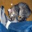

airplane	-2.2607616362304	
automobile	-2.2591948798227	
bird	-2.4056875493871	
cat	-2.2200501754549	
deer	-2.2818115048846	
dog	-2.2440634159106	
frog	-2.3221033707401	
horse	-2.3391186260097	
ship	-2.3438789970701	
truck	-2.3652368553647	
ship	


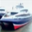

airplane	-2.2069371694499	
automobile	-2.2597662602287	
bird	-2.3443457321722	
cat	-2.2061078158747	


deer	-2.3295822518698	
dog	-2.1888694604522	
frog	-2.4490895003536	
horse	-2.3193758353375	
ship	-2.4150947456584	
truck	-2.3423262186397	
ship	


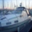

airplane	-2.2395767133471	
automobile	-2.2553846376028	
bird	-2.3772481548522	
cat	-2.2412660192815	
deer	-2.2741069827577	
dog	-2.2489423093966	
frog	-2.3559797305465	
horse	-2.2939947627692	
ship	-2.3811797704653	
truck	-2.3748385755185	
airplane	


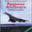

airplane	-2.2632705644252	
automobile	-2.2157213094752	
bird	-2.3663722722235	
cat	-2.181888732412	
deer	-2.2652088175178	
dog	-2.2964405457871	
frog	-2.3609326862141	
horse	-2.3472436925757	
ship	-2.3878446146331	
truck	-2.36392814382	
frog	


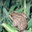

airplane	-2.2081326779512	
automobile	-2.259753180643	
bird	-2.3703897809898	
cat	-2.2159050403987	
deer	-2.3600421144995	
dog	-2.2955379320901	
frog	-2.3184079055652	
horse	

-2.3149729772999	
ship	-2.3723630951716	
truck	-2.3265044550922	
frog	


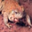

airplane	-2.2405707093482	
automobile	-2.1839889091318	
bird	-2.4273125957433	
cat	-2.1914661109388	
deer	-2.2829381193769	
dog	-2.2805533890792	
frog	-2.330255907723	
horse	-2.3941163439462	
ship	-2.3429874208685	
truck	-2.3837081796835	
automobile	


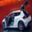

airplane	-2.2185663523217	
automobile	-2.249701939899	
bird	-2.4158400572962	
cat	-2.230050901034	
deer	-2.1801739432213	
dog	-2.3250162900352	
frog	-2.2895130659127	
horse	-2.377350406983	
ship	-2.3584345070354	
truck	-2.4134564115954	
frog	


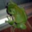

airplane	-2.2398125646272	
automobile	-2.224252602784	
bird	-2.3843059515923	
cat	-2.1989588215922	
deer	-2.3459485284589	
dog	-2.2791641207316	
frog	-2.3324846652883	
horse	-2.2944832306796	
ship	-2.349637585407	
truck	-2.3979486186385	
cat	


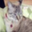

airplane	-2.2725706284777	
automobile	-2.2270358828512	
bird	-2.3626019655349	
cat	-2.1735237755706	
deer	-2.3468825268618	
dog	-2.2880853540647	
frog	-2.3152003303764	
horse	-2.3598128361683	
ship	-2.3706384773309	
truck	-2.3287058688136	
automobile	


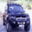

airplane	-2.2182279213985	
automobile	-2.2474278611487	
bird	-2.3558936947739	
cat	-2.24667586447	
deer	-2.263954328191	
dog	-2.2415095798363	
frog	-2.4075006882777	
horse	-2.3317908086878	
ship	-2.3686054320578	
truck	-2.3648947016497	
airplane	


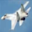

airplane	-2.2494164756872	
automobile	-2.2812273796274	
bird	-2.3339361610402	
cat	-2.2168107007284	
deer	-2.2741487356978	
dog	-2.3041998656311	
frog	-2.333960845699	
horse	-2.3260655443443	
ship	-2.3564748424173	
truck	-2.3597510729806	
truck	


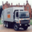

airplane	-2.1996296463164	
automobile	-2.2787021263079	
bird	-2.3752721915271	
cat	-2.1812896273024	
deer	-2.2805277476271	
dog	-2.2536162914289	
frog	-2.3861145531085	
horse	-2.340618722513	
ship	-2.3719394395092	
truck	-2.3854160043396	
dog	


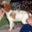

airplane	-2.2586626263498	
automobile	-2.2629413203973	
bird	-2.4065641586351	
cat	-2.2185661947809	
deer	-2.3230926391059	
dog	-2.2520595639734	


frog	-2.2670587973538	
horse	-2.3535736970277	
ship	-2.3670609790899	
truck	-2.3328104723136	
horse	


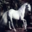

airplane	-2.2460022586454	
automobile	-2.3143845225156	
bird	-2.27921074314	
cat	-2.1527592255064	
deer	-2.2696049025217	
dog	-2.3148091293403	
frog	-2.3951548972443	
horse	-2.3146242577652	
ship	-2.4068918021116	
truck	-2.3577952677517	
truck	


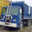

airplane	-2.2255012121917	
automobile	-2.2923860892229	
bird	-2.3371801172997	
cat	-2.2080463960541	
deer	-2.3127624724872	
dog	-2.2774345338033	
frog	-2.3644646133944	
horse	-2.2610875619241	
ship	-2.4078164782472	
truck	-2.357420216685	
ship	


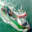

airplane	-2.2115722672818	
automobile	-2.2859283104213	
bird	-2.3768469755775	
cat	-2.237659239546	
deer	-2.303056329592	
dog	-2.2909976508743	
frog	-2.3672921557727	
horse	-2.2528117295019	
ship	-2.3523186493613	
truck	-2.3630033126879	
dog	


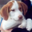

airplane	-2.3399526152119	
automobile	-2.274610808835	
bird	-2.4817286265781	
cat	-2.2382407178244	
deer	-2.2680256250675	
dog	-2.1863603717883	
frog	-2.3362897218253	
horse	-2.3031215869786	
ship	-2.296121075804	
truck	-2.3282663132476	
horse	


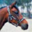

airplane	-2.216547112266	
automobile	-2.2720546024266	
bird	-2.3964170594544	
cat	-2.1754652353471	
deer	-2.3582448708654	
dog	-2.2692035825698	
frog	-2.2889718791378	
horse	-2.3290370225395	
ship	-2.3710241113045	
truck	-2.3731097781424	
ship	


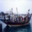

airplane	-2.2457112674217	
automobile	-2.2357938219845	
bird	-2.389836240875	
cat	-2.2268954313372	
deer	-2.2981483963491	
dog	-2.2160638324425	
frog	-2.4416508909768	
horse	-2.3141554599203	
ship	-2.3638690619522	
truck	-2.3194398787635	
frog	


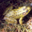

airplane	-2.2174113324291	
automobile	-2.2454325772303	


bird	-2.3138768380662	
cat	-2.1888664743565	
deer	-2.3212917568004	
dog	-2.3027174459418	
frog	-2.3945178041614	
horse	-2.3198189075492	
ship	-2.3981667090599	
truck	-2.3456925573091	
horse	


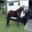

airplane	-2.1614898110938	
automobile	-2.2516611965498	
bird	-2.3875290362712	
cat	-2.1755813731312	
deer	-2.2997246908325	
dog	-2.2577007340692	
frog	-2.3822068875321	
horse	-2.2613147318999	
ship	-2.4729426265471	
truck	-2.4253135524495	
airplane	


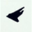

airplane	-2.1871733981457	
automobile	-2.2394715960773	
bird	-2.3567551537074	
cat	-2.2559132495189	
deer	-2.2712884945454	
dog	-2.2562125087657	
frog	-2.268842680853	
horse	-2.3234625222014	
ship	-2.4419266253791	
truck	-2.4596791737517	
deer	


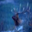

airplane	-2.2085839132855	
automobile	-2.2255779746464	
bird	-2.3400440169579	
cat	-2.1998021522725	
deer	-2.3131010640235	
dog	-2.3057894032199	
frog	-2.3479848315142	
horse	-2.3323815132908	
ship	-2.3978252526867	
truck	-2.37714556594	
truck	


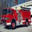

airplane	-2.1466975768152	
automobile	-2.212735320154	
bird	-2.4295507160354	
cat	-2.2360951838311	
deer	-2.3223594784776	
dog	-2.3192142988773	
frog	-2.341882587299	
horse	-2.2705099620539	
ship	-2.3626578410025	
truck	-2.4212590402848	
dog	


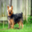

airplane	-2.2198059581704	
automobile	-2.2089503521454	
bird	-2.388715487793	
cat	-2.2772023481175	
deer	-2.3106210444792	
dog	-2.2237405142434	
frog	-2.4180181024144	
horse	-2.3058738935668	
ship	-2.3648643651419	
truck	-2.3320059985351	
bird	


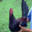

airplane	-2.2252130577045	
automobile	-2.2666357310239	
bird	-2.3563614981865	
cat	-2.2321079340767	
deer	-2.2777608162899	
dog	-2.3035418325814	
frog	-2.4072216460545	
horse	-2.2775565733533	
ship	-2.380699614995	
truck	-2.3154117050239	
deer	


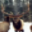

airplane	-2.2163497848359	
automobile	-2.1772185657704	
bird	-2.4238648606295	
cat	-2.2521912332836	
deer	-2.3162105210101	
dog	-2.2775608594739	
frog	-2.3810233423644	
horse	-2.3118380642016	
ship	-2.3412122209709	
truck	-2.3542607662394	
airplane	


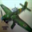

airplane	-2.1721948075875	
automobile	-2.2914909026247	
bird	-2.401649428858	
cat	-2.2197942849731	
deer	-2.3481175074925	
dog	-2.2724846052904	
frog	-2.3383232021037	
horse	

-2.2770813169057	
ship	-2.3951997002108	
truck	-2.3338116719894	
truck	


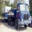

airplane	-2.2142191348161	
automobile	-2.2704532136505	
bird	-2.3763480912185	
cat	-2.1906590556516	
deer	-2.2854198820079	
dog	-2.2601318756106	
frog	-2.4308257164215	
horse	-2.2822910231181	
ship	-2.3864603038444	
truck	-2.3567595463878	
frog	


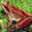

airplane	-2.2249238657522	
automobile	-2.1998650455874	
bird	-2.4171829391373	


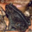

cat	-2.2193030391064	
deer	-2.337828936066	
dog	-2.2916169099448	
frog	-2.2819874210503	
horse	-2.3061355108543	
ship	-2.2942719051497	
truck	-2.4883414880369	
frog	


airplane	-2.2294254161712	
automobile	-2.2060407285797	
bird	-2.4186273562919	
cat	-2.2150610250812	
deer	-2.3107236386433	
dog	-2.3124331311347	
frog	-2.2622875964864	
horse	-2.3469832622622	
ship	-2.3096225025843	
truck	-2.4440823238152	
dog	


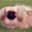

airplane	-2.2291735738487	
automobile	-2.1482357275071	
bird	-2.4526486171267	
cat	-2.2000181137468	
deer	-2.3803733844637	
dog	-2.2681446885082	
frog	-2.3149339339542	
horse	-2.354878256512	
ship	-2.3597755350868	
truck	-2.3571776411029	
deer	


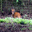

airplane	-2.2576951390284	
automobile	-2.2236845600381	
bird	-2.3995600250155	
cat	-2.22595972871	
deer	-2.3130149428858	
dog	-2.2590040460568	
frog	-2.3260564938821	
horse	-2.3228011624125	
ship	-2.3709696543337	
truck	-2.3434954288559	
dog	


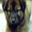

airplane	-2.2366775158899	
automobile	-2.2813738956228	
bird	-2.3960299032706	
cat	-2.2218254120875	
deer	-2.2599370408734	
dog	-2.2739067713747	
frog	-2.3314780026346	
horse	-2.3199311903674	
ship	-2.3360937421192	
truck	-2.3843364456206	
truck	


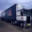

airplane	-2.2007935159892	
automobile	-2.2575496118982	
bird	-2.3523627655072	
cat	-2.1837359261659	
deer	-2.2920189844175	
dog	-2.3482869044756	
frog	-2.3564930326676	
horse	-2.3038843622934	
ship	-2.372842368959	
truck	-2.3807438713608	
bird	


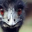

airplane	-2.2274428396463	
automobile	-2.2870158888288	
bird	-2.3375553485757	
cat	-2.2022609082291	
deer	-2.29825878794	
dog	-2.3018818603908	
frog	-2.3755361755319	
horse	-2.3337570019783	
ship	-2.3539864614194	
truck	-2.3215473938506	
deer	


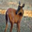

airplane	-2.2085379109893	
automobile	-2.1950344496685	
bird	-2.4411563349328	
cat	-2.2356486218817	
deer	-2.315385327034	
dog	-2.2534380496082	
frog	-2.3055183301464	
horse	-2.361005007554	
ship	-2.3531613868272	
truck	-2.3866734452253	
automobile	


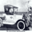

airplane	-2.292890379082	
automobile	-2.2435287311057	
bird	-2.3572993771216	
cat	-2.2386520075993	
deer	-2.2117550354046	
dog	-2.2695583567942	
frog	-2.4185762229069	
horse	-2.2628921028828	
ship	-2.3799145568833	
truck	-2.3736235098976	
truck	


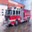

airplane	-2.1927192811658	
automobile	-2.1822114222429	
bird	-2.4490778293012	
cat	-2.250290745439	
deer	-2.2726131812565	
dog	-2.2889933544082	
frog	-2.3831793016442	
horse	-2.3251477255214	
ship	-2.3116614999025	
truck	-2.4043932048169	
dog	


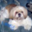

airplane	

-2.2269883107939	
automobile	-2.2779965371339	
bird	-2.3386901073636	
cat	-2.2390968699374	
deer	-2.3065975885302	
dog	-2.2919556295474	
frog	-2.3486614952825	
horse	-2.2995402512742	
ship	-2.3906851561726	
truck	-2.3165585838456	
deer	


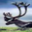

airplane	

-2.2362088141144	
automobile	-2.3400517794705	
bird	-2.3635996166711	
cat	-2.1481606207831	
deer	-2.3588022367278	
dog	-2.3070051037422	
frog	-2.3565162585079	
horse	-2.2843507812464	
ship	-2.4032631956433	
truck	-2.2544594340271	
frog	


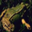

airplane	-2.2371840983035	
automobile	-2.2407854956026	
bird	-2.3771410639933	
cat	-2.1961381534778	
deer	-2.3177761546985	
dog	-2.3043937141146	
frog	-2.3411758296394	
horse	-2.2776708850321	
ship	-2.3361200744672	
truck	-2.4183551625986	
dog	


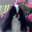

airplane	-2.1636595867739	
automobile	-2.2070176949623	
bird	-2.3883829430958	
cat	-2.2089502381484	
deer	-2.3727375348915	
dog	-2.3601965171294	
frog	-2.3127953787135	
horse	-2.2791223747038	
ship	-2.3313921119341	
truck	-2.4380773161153	
frog	


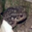

airplane	-2.2262462151963	
automobile	-2.2540635511784	
bird	-2.4024732410576	
cat	-2.2444876787615	


deer	-2.3014342517553	
dog	-2.3060504531159	
frog	-2.2794644597485	
horse	-2.3413306233914	
ship	-2.2881800607343	
truck	-2.398424424329	
airplane	


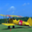

airplane	-2.2209383346865	
automobile	-2.273776678832	
bird	

-2.3362175613215	
cat	-2.2084467852734	
deer	-2.3268571933191	
dog	-2.3220225935789	
frog	-2.4739865148729	
horse	-2.3118900219905	
ship	-2.3942254437682	
truck	-2.1913688438001	
truck	


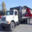

airplane	-2.2104637406367	
automobile	-2.3081194249395	


bird	-2.3378711481089	
cat	-2.2093251216225	
deer	-2.3897608693684	
dog	-2.2900677237916	
frog	-2.3641506000439	
horse	-2.2349299039525	
ship	-2.3308468687452	
truck	-2.370423634494	
cat	


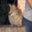

airplane	-2.2444909372899	
automobile	-2.211314882565	
bird	-2.3844156787937	
cat	-2.2078474139666	
deer	-2.3080865846739	
dog	-2.2919682606713	
frog	-2.3109874113141	
horse	-2.3890867346383	
ship	-2.3685760721962	
truck	-2.3292078496235	
truck	


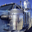

airplane	-2.2500190785871	
automobile	-2.271071373869	
bird	-2.3301988737655	
cat	-2.2455223876348	
deer	-2.2876137776074	
dog	-2.2721370218067	
frog	-2.3917075146345	
horse	-2.2942052955918	
ship	-2.3885089876867	
truck	-2.30688112795	
horse	


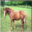

airplane	-2.2280016188542	
automobile	-2.2272023180474	
bird	-2.3966141259678	
cat	-2.2155865861794	
deer	-2.3579729366528	
dog	-2.3022565193325	
frog	-2.3241714742287	
horse	-2.2747559409629	


ship	-2.3786360731387	
truck	-2.3402497179687	
frog	


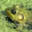

airplane	-2.246161701931	
automobile	-2.1640667753696	
bird	-2.4386214862163	
cat	-2.1997965330579	
deer	-2.3132325897113	
dog	-2.2957655232835	
frog	-2.3192741474461	
horse	-2.3406838456019	
ship	-2.3369927704849	
truck	-2.4037111572576	
truck	


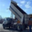

airplane	-2.2101721736612	
automobile	-2.3403098551856	
bird	-2.2507355733939	
cat	-2.2176229351313	
deer	-2.2304896444013	
dog	-2.2893866073237	
frog	-2.4050812699696	
horse	-2.2784932032301	
ship	-2.3811041742718	
truck	-2.4547845668185	
ship	


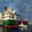

airplane	-2.2065842205815	
automobile	-2.2501954480451	
bird	-2.3312200444225	
cat	-2.2079432066979	
deer	-2.3336359176498	
dog	-2.2407108401202	
frog	-2.4400259222024	
horse	-2.3030735162698	
ship	-2.3890002483865	
truck	-2.3508812036976	
airplane	


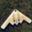

airplane	-2.2393361576108	
automobile	-2.279177024336	
bird	-2.4263849627416	
cat	-2.2010819606554	
deer	-2.2723207476766	
dog	-2.2753358157013	
frog	-2.3687030182635	
horse	-2.314100736477	
ship	-2.3444142752622	
truck	

-2.3241372725347	
cat	


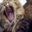

airplane	-2.2320033924652	
automobile	-2.1878149302375	
bird	-2.4014654571371	
cat	-2.2285146220656	
deer	-2.3238345122292	
dog	-2.3137833921378	
frog	-2.3227246813567	
horse	-2.2974033776924	
ship	-2.3473728044041	
truck	-2.3933613971476	
ship	


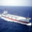

airplane	-2.2553685017913	
automobile	-2.2715639489151	
bird	-2.3400121819383	
cat	-2.2408916097491	
deer	-2.2677191247887	
dog	-2.2551045172772	
frog	-2.3975781184335	
horse	-2.3100425313653	
ship	-2.3403432664533	
truck	-2.3599593455254	
ship	


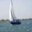

airplane	-2.2433491224796	
automobile	-2.2125709491487	
bird	-2.3650667947773	
cat	-2.2182707576647	
deer	-2.3132358426685	
dog	-2.2575670718163	
frog	-2.3598743201048	
horse	-2.3570069423097	
ship	-2.3612359035585	
truck	-2.3564694631907	
horse	


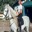

airplane	-2.2410967088297	
automobile	-2.3806918701152	
bird	-2.34551975361	


cat	-2.1694345397985	
deer	-2.3037237071172	
dog	-2.3250447947874	
frog	-2.4688688308178	
horse	-2.204905939746	
ship	-2.3996822688909	
truck	-2.2276772320818	
horse	


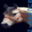

airplane	-2.2062452438306	
automobile	-2.229083406919	
bird	-2.374771103099	
cat	-2.1553452420563	
deer	-2.3653700348002	
dog	-2.3268075009797	
frog	-2.3212906877513	
horse	-2.2817869196564	
ship	-2.4168192747123	
truck	-2.3817803828225	
deer	


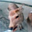

airplane	-2.2210570465021	
automobile	-2.2999105354167	
bird	-2.3655742347963	
cat	-2.2279853321251	
deer	-2.3310617626481	
dog	-2.2718267665269	
frog	-2.3283223034851	
horse	-2.2886493846558	
ship	-2.3592306845341	
truck	-2.3441811694269	
frog	


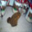

airplane	-2.2060932770645	
automobile	-2.2486760730486	
bird	-2.3521410564183	
cat	-2.2047871817726	
deer	-2.294932577202	
dog	-2.2916206760763	
frog	-2.3670287578682	
horse	-2.3456206322293	
ship	-2.3867164178621	
truck	-2.3481729828066	
horse	


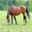

airplane	-2.2148645779032	


automobile	-2.2267633030594	
bird	-2.4069093673533	
cat	-2.2180043764367	
deer	-2.2779865354894	
dog	-2.2582842528093	
frog	-2.3536837897099	
horse	-2.3052230461843	
ship	-2.393960715391	
truck	-2.3969756330204	
cat	


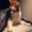

airplane	-2.2259863951846	
automobile	-2.1625705029219	
bird	-2.4007998078044	
cat	-2.1711838390059	
deer	-2.3539788281556	
dog	-2.2965254999315	
frog	-2.2729733159569	
horse	-2.4108527153319	
ship	-2.376958437387	
truck	-2.3952800010032	
frog	


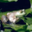

airplane	-2.2346944704234	
automobile	-2.2926956964603	
bird	-2.3600412640138	
cat	-2.212830556516	
deer	-2.2559680905449	
dog	-2.3012584589291	
frog	-2.3438419945563	
horse	-2.3019054216817	
ship	-2.3607521787262	
truck	-2.3762947703493	
cat	


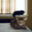

airplane	-2.198593384904	
automobile	-2.3034489007731	
bird	-2.392375778741	
cat	-2.2255399932649	
deer	-2.2759254533646	
dog	-2.2163669895673	
frog	-2.3975073093142	
horse	-2.3130539501625	
ship	-2.3955714736612	
truck	-2.3332903890295	
frog	


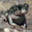

airplane	-2.1979725573693	
automobile	-2.2855394425445	
bird	-2.4002926565662	
cat	-2.2260687345516	
deer	-2.3452184460955	
dog	-2.3012316180451	
frog	-2.2556142356428	
horse	-2.2987091645235	
ship	-2.3297290684691	
truck	-2.4065234057217	
bird	


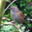

airplane	-2.2183498776011	
automobile	-2.2714461576495	
bird	-2.3725872830002	
cat	-2.209717928881	
deer	-2.3219092963905	
dog	-2.3027948928224	
frog	-2.3009946310485	
horse	-2.3391128948252	
ship	-2.376195444287	
truck	-2.3275229593304	
automobile	


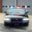

airplane	-2.2578256253074	
automobile	-2.2333934020697	
bird	-2.396902601955	
cat	-2.1604134871448	
deer	-2.3053332142927	
dog	-2.2640809233705	
frog	-2.4411650083572	
horse	-2.2913547218814	
ship	-2.3838208814934	
truck	-2.3233598782576	
bird	


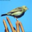

airplane	-2.2125177018646	
automobile	-2.388448967124	
bird	-2.3228142519834	
cat	-2.2508029040259	
deer	-2.3097894761518	
dog	-2.2224078323312	
frog	-2.4329559660656	
horse	-2.1846366833486	
ship	-2.4261672636533	
truck	-2.3107111297235	
cat	


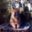

airplane	-2.1818581375194	
automobile	-2.299227347978	
bird	-2.3926205442959	
cat	-2.1786743788991	
deer	-2.3234107117054	
dog	-2.3354638112752	
frog	-2.3265667934248	
horse	-2.306135912576	
ship	-2.3705325267962	
truck	-2.3347034646225	
horse	


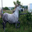

airplane	-2.2249186222648	
automobile	-2.3145405207025	
bird	-2.3368771827943	
cat	-2.2247254291575	
deer	-2.3267855179957	
dog	-2.2544264928386	
frog	-2.3747941717909	
horse	-2.2582166274925	
ship	-2.3588314516571	
truck	-2.3672038642131	
bird	


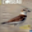

airplane	-2.2631507341871	
automobile	-2.2064604749965	
bird	-2.3981857422221	
cat	-2.2500280153158	
deer	-2.2852910054642	
dog	-2.2423232450646	
frog	-2.3694955717135	
horse	-2.3439845385731	
ship	-2.3379348764308	
truck	-2.3470173872029	
frog	


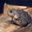

airplane	-2.2250945275095	
automobile	-2.2299350723279	
bird	-2.3807318670718	
cat	-2.174054914124	
deer	-2.3547982009149	
dog	-2.290277390458	
frog	-2.3385818982596	
horse	-2.330815206312	
ship	-2.380188455144	
truck	-2.3450337123579	
ship	


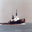

airplane	-2.2543527485687	
automobile	-2.2161924211538	
bird	-2.3683881704876	
cat	-2.2029817179041	
deer	-2.3147481337423	
dog	-2.256357247181	
frog	-2.3528052565433	
horse	-2.3799614541174	
ship	-2.3472658023545	
truck	-2.3525998152025	
ship	


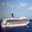

airplane	-2.2431281784025	
automobile	-2.2468946145113	
bird	-2.365348520422	
cat	-2.2019240549477	
deer	-2.3290575905112	
dog	-2.2740946396143	
frog	-2.3427189749792	
horse	-2.3453889816275	
ship	-2.37786954601	
truck	-2.3152777959636	
airplane	


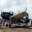

airplane	-2.2210109149197	
automobile	-2.2290009120013	
bird	-2.4398038367773	
cat	-2.2148190872318	
deer	-2.3211453492018	
dog	-2.2766116371716	
frog	-2.4314497954761	
horse	-2.2696843943752	
ship	-2.3366327928073	
truck	-2.3145117552555	
bird	


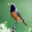

airplane	-2.1959453756369	
automobile	-2.2576615139475	
bird	-2.3614261628376	
cat	-2.232554711413	
deer	-2.305752324173	
dog	-2.3060343021676	
frog	-2.3789608939978	
horse	-2.2476653643103	
ship	-2.3458663336354	
truck	-2.416693730674	
truck	


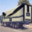

airplane	-2.2254259373369	
automobile	-2.3145484697549	
bird	-2.4308803887329	
cat	-2.1349029137469	
deer	-2.3496552020342	
dog	-2.2994075002733	
frog	-2.3277680797454	
horse	-2.253290822512	
ship	-2.3562572593035	
truck	-2.365613310691	
cat	


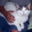

airplane	-2.2217520688462	
automobile	-2.2356099720874	
bird	-2.3930505967271	
cat	-2.1872718577945	
deer	-2.331254464675	
dog	-2.3261327224787	
frog	-2.3355186808583	
horse	-2.3320910814923	
ship	-2.3987741140605	
truck	-2.2871791923065	
cat	


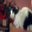

airplane	-2.2178039491472	
automobile	-2.2387903367385	
bird	-2.38823992596	
cat	-2.1372974037289	
deer	-2.329516046472	
dog	-2.3164000461467	
frog	-2.2508131461975	
horse	-2.3860472556307	
ship	-2.3948296031062	
truck	-2.4042280819366	
ship	


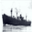

airplane	-2.2864927047694	
automobile	-2.264282627997	
bird	-2.3994911906797	
cat	-2.1960471562383	
deer	-2.3147919802589	
dog	-2.2070337345434	
frog	-2.3860718439817	
horse	-2.3549320507149	
ship	-2.3387993682261	
truck	-2.2993886773193	
ship	


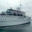

airplane	-2.243618799401	
automobile	-2.2435627520586	
bird	-2.3818837344166	
cat	-2.2464515974806	
deer	-2.3197519590432	
dog	-2.2471864226885	
frog	-2.3576008614893	
horse	-2.2836068315087	
ship	-2.3408997643354	
truck	-2.3762559987171	
automobile	


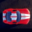

airplane	-2.2524943460564	
automobile	-2.1414994712155	
bird	-2.3856634483507	
cat	-2.1669182172182	
deer	-2.293941399913	
dog	-2.3412885047735	
frog	-2.2562023146523	
horse	-2.3938227661624	
ship	-2.3556309739734	
truck	-2.4901938984941	
automobile	


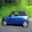

airplane	-2.2087191396432	
automobile	-2.2402392797827	
bird	-2.359023060389	
cat	-2.2019577164469	
deer	-2.288160480327	
dog	-2.2709505710413	
frog	-2.4045443191647	
horse	-2.3335794727747	
ship	-2.381758010627	
truck	-2.3610931465806	
horse	


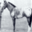

airplane	-2.2375859812612	
automobile	-2.2790989701897	
bird	-2.3350070367846	
cat	-2.1943970630632	
deer	-2.3215457588863	
dog	-2.2474654381166	
frog	-2.3586040112477	
horse	-2.3350141896329	
ship	-2.3625837179292	
truck	-2.371442889169	
bird	


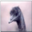

airplane	-2.2729836401252	
automobile	-2.2257517056504	
bird	-2.3668219182594	
cat	-2.2106144174089	
deer	-2.3356517528398	
dog	-2.2275060155814	
frog	-2.3374555645599	
horse	-2.3099763027765	
ship	-2.3247059195571	
truck	-2.437206984999	
dog	


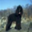

airplane	-2.2170705988112	
automobile	-2.2543833093308	
bird	-2.4051585623364	
cat	-2.2413894365486	
deer	-2.3250679286416	
dog	-2.2849344397626	
frog	-2.3967087736659	
horse	-2.201342748437	
ship	-2.3449094822903	
truck	-2.3806845690413	
bird	


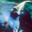

airplane	-2.1298255102713	
automobile	-2.2986198359481	
bird	-2.238140729259	
cat	-2.1763369444197	
deer	-2.4111188667396	
dog	-2.3979147587941	
frog	-2.3256630802858	
horse	-2.2443450073117	
ship	-2.4299370777918	
truck	-2.4275641357555	
horse	


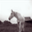

airplane	-2.2178424257308	
automobile	-2.2384579771697	
bird	-2.3003567459488	
cat	-2.2270895890523	
deer	-2.3273457451064	
dog	-2.224969725685	
frog	-2.3851358169172	
horse	-2.359254245404	
ship	-2.4006838578475	
truck	-2.3685059996031	
ship	


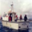

airplane	-2.2296338159189	
automobile	-2.2066170639837	
bird	-2.3556376619532	
cat	-2.2309140496615	
deer	-2.3120379566256	
dog	-2.2681803826671	
frog	-2.37961099784	
horse	-2.2890348992809	
ship	-2.3523118145563	
truck	-2.4254612384166	
truck	


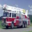

airplane	-2.2387086836609	
automobile	-2.2457300082532	
bird	-2.3796694826641	
cat	-2.1700157997094	
deer	-2.2960158199545	
dog	-2.2721345909172	
frog	-2.3910142597017	
horse	-2.3206517647938	
ship	-2.4096213123289	
truck	-2.3284151301232	
airplane	

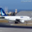

airplane	-2.251843641501	
automobile	-2.2499158883135	
bird	-2.3954767934952	
cat	-2.2233485466258	
deer	-2.3087785917225	
dog	-2.2278174628522	
frog	-2.3877696228823	
horse	-2.2917867437374	
ship	-2.3609858658545	
truck	-2.347389112337	
cat	


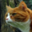

airplane	-2.211070108781	
automobile	-2.2194488025862	
bird	-2.4296812399583	
cat	-2.1963481794534	
deer	-2.330924708199	
dog	-2.2665184549606	
frog	-2.3009206417415	
horse	-2.3328779465497	
ship	-2.3509436450722	
truck	-2.4176142463348	
ship	


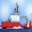

airplane	-2.2099374439236	
automobile	-2.2714033067181	
bird	-2.2642729482576	
cat	-2.1815538285244	
deer	-2.3435571566554	
dog	-2.2406920330497	
frog	-2.4279627468143	
horse	-2.3703895628089	
ship	-2.4213466093172	
truck	-2.3276924478353	
frog	


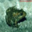

airplane	-2.1905308930266	
automobile	-2.2817012525238	
bird	-2.3709365104988	
cat	-2.2672457073194	
deer	-2.2981744254576	
dog	-2.2946794326639	
frog	-2.3831563127397	
horse	-2.2116293020696	
ship	-2.3676348920109	
truck	-2.3824602058394	
deer	


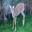

airplane	-2.2279024265128	
automobile	-2.2206026654054	
bird	-2.3576272420708	
cat	-2.1967810082863	
deer	-2.305129566655	
dog	-2.3221575459281	
frog	-2.3606134579492	
horse	-2.3316024887978	
ship	-2.3697839749086	
truck	-2.352970170525	
frog	


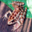

airplane	-2.1888487775457	
automobile	-2.2596267660101	
bird	-2.3818876326755	
cat	-2.2275296229196	
deer	-2.3299131199303	
dog	-2.3215027495553	
frog	-2.3365801461487	
horse	-2.2702654201122	
ship	-2.3480865956903	
truck	-2.3808706070263	
frog	


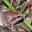

airplane	-2.220745156144	
automobile	-2.2577619785848	
bird	-2.4104106039268	
cat	-2.177233604716	
deer	-2.3516152722964	
dog	-2.3198470466107	
frog	-2.339719909159	
horse	-2.2375196323226	
ship	-2.3742156160607	
truck	-2.3635507338866	
airplane	


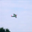

airplane	-2.2461177639449	
automobile	-2.1879730447585	
bird	-2.3732334274529	
cat	-2.2204979561611	
deer	-2.3146897506442	
dog	-2.2719585873467	
frog	-2.3269148410955	
horse	-2.3843758341478	
ship	-2.3727235305398	
truck	-2.3492912666473	
airplane	


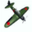

airplane	-2.2624020542687	
automobile	-2.3681126537599	
bird	-2.2782896425247	
cat	-2.1810398204415	
deer	-2.2913934594893	
dog	-2.2926682190216	
frog	-2.3104738100989	
horse	-2.2678513593591	
ship	-2.4072878348227	
truck	-2.3867357158085	
horse	


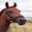

airplane	-2.1962890029064	
automobile	-2.2396646390557	
bird	-2.3204448135926	
cat	-2.19635679382	
deer	-2.341083113417	
dog	-2.3322400523115	
frog	-2.3130132664721	
horse	-2.2979310007844	
ship	-2.4122868869107	
truck	-2.4022663396465	


In [28]:
for j=1,100 do
    print(classes[testset.label[j]])
    itorch.image(testset.data[j])
    predicted = net:forward(testset.data[j])
    for i=1,predicted:size(1) do
        print(classes[i], predicted[i])
    end
end

airplane	-0.6286669238626	
automobile	-5.1320282521955	
bird	-4.0228367310445	
cat	-1.2291132696034	
deer	-3.6684096266702	
dog	-6.0169452493418	
frog	-6.2993962063605	
horse	-2.4274976300882	
ship	-6.7313345581791	
truck	-3.4733122610114	
